# Text Mining of Movie Synopsis

<img src='cover.jpg'>

### Hipotezy projektu:
<ul>
<li>Czy klasteryzacja na podstawie odpowiednio wyczyszczonych słów kluczowych będzie się pokrywać z rzeczywistymi gatunkami filmów
<li>Czy najczestsze slowa z podzialem na gatunki roznia sie miedzy soba
</ul>

W projekcie, probowaliśmy wyjaśnić, jak zebrać zestaw dokumentów. Naszym motywującym przykładem jest identyfikacja ukrytych struktur w obrębie streszczeń 100 najlepszych filmów z czterech wybranych kategorii (według listy IMDB): romans, komedia, akcja, fantazja. Analiza obejmuje:

<ul>
<li> tokenizacja i stemming kazdego streszczenia
<li> transformacja korpusu do przestrzeni wektorow uzywajac [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> obliczenie cosinusowych odleglosci miedzy kazdym dokumentem jako miara podobienstwa
<li> klasteryzacja z wykorzystaniem [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> klasteryzacja hierarchiczna z uzyciem [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> wykres dendogramow Warda
</ul>

### Wnioski:

Po dotychczasowych badaniach empirycznych droga iteracji, w wytrenowanym modelu nie otrzymalismy pokrycia w 100 procentach w stosunku liczba klastrow = liczba gatunkow uwzglednionych w eksperymencie, co predstawia [wizualizacja klasteringu](#Wizualizacja-klasteringu). Optymalne bylo utworzenie 3 klastrow, co mozna dodatkowo przeprowadzic metoda lokcia, a dysponujemy liczba 4 gatunkow filmowych.

Hipoteza sformulowana powyzej wydaje sie byc nieprawdziwa, poniewaz wszystkie obserwacje (streszczenia filmow) z kazdego gatunku filmowego sa obecne w kazdym klastrze.

W [analizie klasteringu](#Analiza-klasteringu) przy założeniu 5% szans popełnienia błędu przy wnioskowaniu (p = 0,05), a liczba stopni swobody wynosi 6 to wartość krytyczna testu chi-kwadrat wynosi 12.59. Wynik testu chi-kwadrat w badaniu wyniósł 4.29 to oznacza, że wyniki nie sa istotne statystycznie dla poziomu istotności p = 0,05.

Analiza skupien pokazalaby lepsze rezultaty na wiekszym zbiorze danych, gdzie bylaby nieodzownym narzedziem, wowczas gdy analiza pojedynczych przypadkow traci sens.

### Przyszle prace:
<ul>
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
<li> analiza skupien EM
<li> sieci Kohonena
</ul>

### Pipeline:

Po zakonczeniu procesu pozyskiwania danych:

<ul>
<li>[Konkatenacja danych](#Konkatenacja-danych)
<li>[Czyszczenie korpusu](#Czyszczenie-korpusu)
<li>[Utworzenie czterech korpusow wg gatunku](#Utworzenie-czterech-korpusow-wg-gatunku)
<li>[Konwertowanie do listy](#Konwertowanie-do-listy)
<li>[Macierz tf-idf i porownanie opisow filmow](#Macierz-tf-idf-i-porownanie-opisow-filmow)
<li>[Wytrenowanie modelu KMeans](#Wytrenowanie-modelu-KMeans)
<li>[Skalowanie wielowymiarowe](#Skalowanie-wielowymiarow)
<li>[Wizualizacja klasteringu](#Wizualizacja-klasteringu)
<li>[Analiza klasteringu](#Analiza-klasteringu)
<li>[Hierarchiczny klastering](#Hierarchiczny-klastering)
<li>[Bag of words](#Bag-of-words)
<li>[Wordclouds](#Wordclouds)
</ul>

Zaimportowanie potrzebnych bibliotek:

In [187]:
import re
import sys
import nltk
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import unicodedata
import spacy
import scipy.stats as stats

from nltk.tokenize import word_tokenize
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.cluster import KMeans

##  Konkatenacja danych

In [2]:
cwd = os.getcwd()
print(cwd)
targetdir = "/home/g.mika/Documents/Untitled Folder/IMDB_keyword_analyzer/movies_txt_storylines/"
filelist = os.listdir(targetdir)

rank = list(range(1, 177))
movies_df = pd.DataFrame(index = [rank])
list_ = []


for index, file_ in enumerate(filelist):
    df = pd.read_csv(targetdir + file_,skipinitialspace=True,sep=';;;', header=None)
    df.columns = ['synopses']
    
    file_ = file_.split("/")
    file_ = file_[0].split("_")
    genre = file_[1].split(".")
    genre2 = re.sub('\d+', '', genre[0])
    df['titles'] = file_[0]
    df['genres'] = genre2
    title_prev = ''
    list_.append(df)
    
movies_df = pd.concat(list_)
movies_df

/home/g.mika/Documents/Untitled Folder/IMDB_keyword_analyzer


/home/g.mika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,synopses,titles,genres
0,Three men set out on horseback on a snowy land...,Game of Thrones,action
1,We see their bodies are laid out in a kind of ...,Game of Thrones,action
2,Bran lets fly his arrow and misses wildly.Sudd...,Game of Thrones,action
3,A funeral takes place in the grand cathedral.S...,Game of Thrones,action
4,Cat tells her husband the news of Jon Arryns d...,Game of Thrones,action
5,King Robert of Baratheon and Queen Cersei are ...,Game of Thrones,action
6,They greet each other warmly. Arya is eager to...,Game of Thrones,action
7,"Down there, Robert says Arryn got sick suddenl...",Game of Thrones,action
8,Across the Narrow SeaPrincess Daenerys Targary...,Game of Thrones,action
9,Arya gets removed from the party for flicking ...,Game of Thrones,action


## Czyszczenie korpusu

W tej sekcji przeprowadzono oczyszczenie korpusu w nastepujacej kolejnosci:
<li>Usuniecie znakow specjalnych
<li>NER-y
<li>Usuniecie duzych liter
<li>Tokenizacja
<li>Lematyzacja
<li>Usuniecie stopwords

In [3]:
stop = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', tagger=False, parser=False, matcher=False)

movies_df['synopses'] = movies_df['synopses'].map(lambda x: re.sub(r'[^a-zA-Z_0-9\s]', '', str(x)))
movies_df['tokens'] = movies_df['synopses'].apply(word_tokenize) 

string=' '.join(str(r) for v in movies_df['tokens'] for r in v)
doc = nlp(string)
ner=[]
for entity in doc.ents:
    ner.append(entity.text)
    
movies_df['tokens'] = movies_df['tokens'].apply(lambda x: [item for item in x if item not in ner])
#movies_df['tokens'] = movies_df["tokens"].apply(lambda x: [stemmer.stem(y) for y in x])
movies_df['tokens'] = movies_df["tokens"].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])
#movies_df['tokens'] = movies_df['tokens'].str.lower()
movies_df['tokens'] = movies_df['tokens'].apply(lambda x: [item for item in x if item not in stop])

### Utworzenie czterech korpusow wg gatunku

In [4]:
romance=movies_df.groupby(['genres']).get_group('romance')
comedy=movies_df.groupby(['genres']).get_group('comedy')
fantasy=movies_df.groupby(['genres']).get_group('fantasy')
action=movies_df.groupby(['genres']).get_group('action')

### Konwertowanie do listy

In [5]:
tokens = movies_df['tokens'].tolist()
synopses = movies_df['synopses'].tolist()
titles = movies_df['titles'].tolist()
genres = movies_df['genres'].tolist()

In [6]:
def tokenize_and_stem(text):

    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []

    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):

    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []

    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
stemmer = PorterStemmer()

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

vocab_frame.head(20)

,words
three,three
men,men
set,set
out,out
on,on
horseback,horseback
on,on
a,a
snowi,snowy
landscap,landscape


## Macierz tf-idf i porownanie opisow filmow

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 5.28 s, sys: 7.79 ms, total: 5.29 s
Wall time: 5.28 s
(176, 253)


In [10]:
terms = tfidf_vectorizer.get_feature_names()

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## Wytrenowanie modelu KMeans

In [12]:
from sklearn.cluster import KMeans

num_clusters = 3
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 435 ms


In [13]:
movies = {'rank': rank, 'titles': titles, 'genres': genres, 'clusters': clusters, 'synopses': synopses}
movies_clusters_df = pd.DataFrame(movies , index = [rank] ,columns = ['rank', 'titles', 'genres', 'clusters', 'synopses'])

In [14]:
movies_clusters_df.head()
movies_clusters_df.clusters.value_counts()

1    110
0     59
2      7
Name: clusters, dtype: int64

In [23]:
grouped = movies_clusters_df['rank'].groupby(movies_clusters_df['clusters'])
grouped.mean()

clusters
0    98.847458
1    84.390909
2    65.857143
Name: rank, dtype: float64

W kazdym klastrze znalazly sie filmy z kazdego gatunku, co wiecej rozklad gatunkow w klastrach jest relatywnie rownomierny (klaster 0 - po 2 filmy z kazdego gatunku, klaster 1 - tyle samo komedii i romansow i prawie tyle samo filmow akcji i fantasy). Oznacza to, ze klastry utworzone na podstawie streszczen filmow nie odzwierciedlaja rzeczywistego podzialu na gatunki, wbrew temu co moznaby sie spodziewac.

In [16]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :8]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Top terms per cluster:

Cluster 0 words: b'his', b'asks', b'has', b'wall', b'young', b'house', b'brother', b'watches',
Cluster 1 words: b'his', b'has', b'tells', b'was', b'says', b'before', b'killed', b'try',
Cluster 2 words: b'like', b'learn', b'just', b'looking', b'this', b'father', b'death', b'was',


/home/g.mika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


## Skalowanie wielowymiarowe

In [17]:
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

In [18]:
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split())
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Wizualizacja klasteringu

In [24]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

cluster_names = {0: 'his, asks, has, wall, young, house, brother, watches', 
                 1: 'his, has, tells, was, says, before, killed, try', 
                 2: 'like, learn, just, looking, this, father, death, was'}

In [25]:
%matplotlib inline

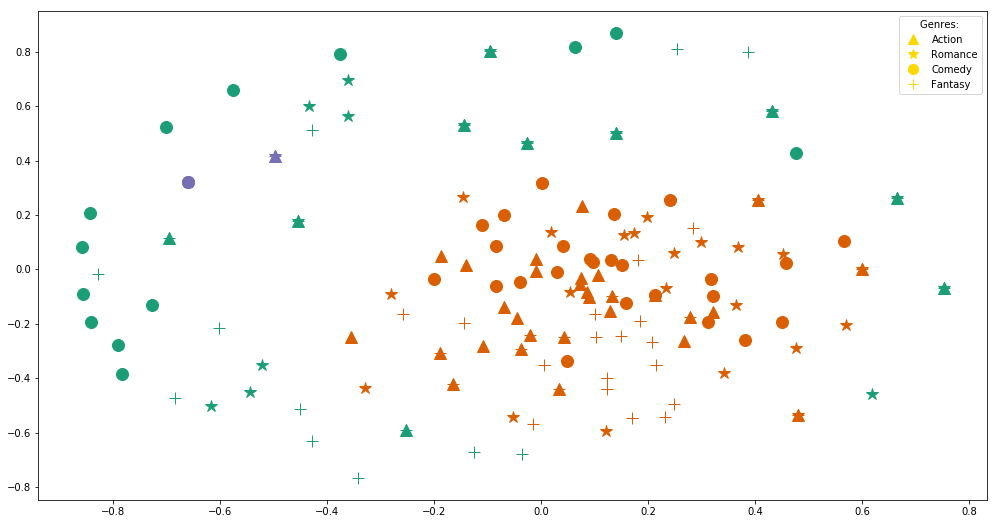

In [220]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles, genres=genres)) 

groups = df.groupby('label')
m = {'action':'^', 'romance':'*', 'comedy':'o', 'fantasy':'+'}

fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05) 

df['markers'] = df['genres'].apply(lambda x: m[x])
df['colors'] = df['label'].apply(lambda x: cluster_colors[x])

for index, row in df.iterrows():
    ax.plot(df.iloc[index]['x'], df.iloc[index]['y'], marker=df.iloc[index]['markers'], linestyle='', ms=12, label=df.iloc[index]['label'], color=df.iloc[index]['colors'])
       
ax.legend(numpoints=1)  

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

action_legend = mlines.Line2D([], [], color='gold', marker='^', linestyle='None',
                          markersize=10, label='Action')
romance_legend = mlines.Line2D([], [], color='gold', marker='*', linestyle='None',
                          markersize=10, label='Romance')
comedy_legend = mlines.Line2D([], [], color='gold', marker='o', linestyle='None',
                          markersize=10, label='Comedy')
fantasy_legend = mlines.Line2D([], [], color='gold', marker='+', linestyle='None',
                          markersize=10, label='Fantasy')

plt.legend(handles=[action_legend, romance_legend, comedy_legend, fantasy_legend], title="Genres: ")

plt.show()

### Analiza klasteringu

In [211]:
df_cross = pd.crosstab(df.genres, df.label, margins=True)

df_cross.columns = ["cluster #1","cluster #2","cluster #3","Totals"]

observed = df_cross.ix[0:4,0:3]
df_cross

/home/g.mika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,cluster #1,cluster #2,cluster #3,Totals
genres,,,,
action,10,29,1,40
comedy,13,25,2,40
fantasy,21,30,1,52
romance,15,26,3,44
All,59,110,7,176


In [212]:
expected =  np.outer(df_cross["Totals"][0:4],
                     df_cross.ix["All"][0:3]) / 176

expected = pd.DataFrame(expected)

expected.columns = ["cluster #1","cluster #2","cluster #3"]
expected.index = ["action","comedy","fantasy","romance"]

expected

,cluster #1,cluster #2,cluster #3
action,13.409091,25.0,1.590909
comedy,13.409091,25.0,1.590909
fantasy,17.431818,32.5,2.068182
romance,14.750000,27.5,1.750000


In [213]:
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

4.2971767215835


In [224]:
row, column = expected.shape
df_chi2 = (row - 1)*(column - 1)

print("Degrees of freedom")
print(df_chi2)
print()

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df = df_chi2)
print("P value")
print(p_value)
print()

crit = stats.chi2.ppf(q = 0.95, df = df_chi2)   

print("Critical value")
print(crit)

Degrees of freedom
6

P value
0.636529172469

Critical value
12.5915872437


In [217]:
stats.chi2_contingency(observed = observed)

(4.2971767215835008,
 0.63652917246906981,
 6,
 array([[ 13.40909091,  25.        ,   1.59090909],
        [ 13.40909091,  25.        ,   1.59090909],
        [ 17.43181818,  32.5       ,   2.06818182],
        [ 14.75      ,  27.5       ,   1.75      ]]))

### Hierarchiczny klastering

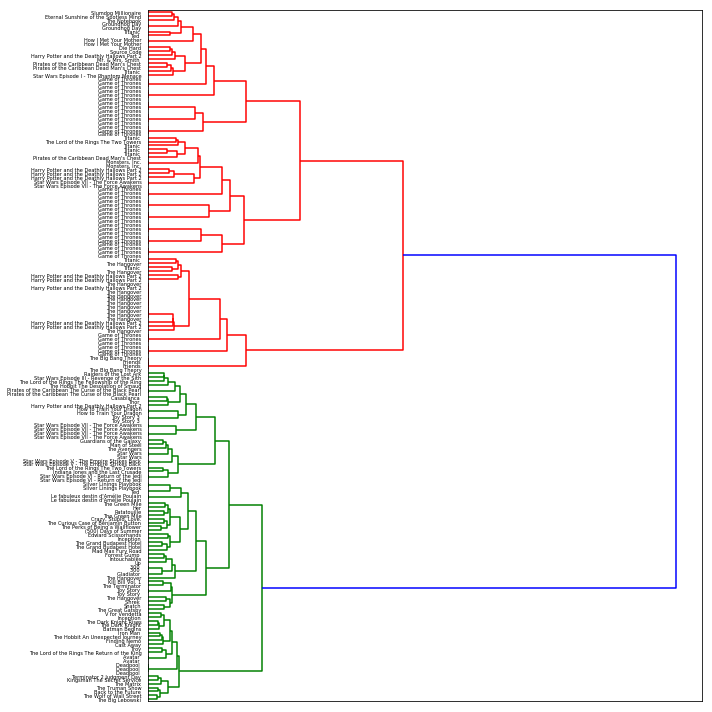

In [22]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 10)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',         
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tight_layout() 


plt.savefig('ward_clusters.png', dpi=200) 

### Bag of words

In [ ]:
count = Counter(lower_tokens)
alpha_only = [t for t in lower_tokens if t.isalpha()]
english_stops = set(stopwords.words('english'))
no_stops = [t for t in alpha_only if t not in english_stops]
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
bow = Counter(lemmatized)

print(bow.most_common(10))

### NER-y (Named Entity Recognition)

In [9]:
alphanum = [t for t in tokens if t.isalpha()]
string=' '.join(set(alphanum))
nlp = spacy.load('en_core_web_sm', tagger=False, parser=False, matcher=False)
doc = nlp(string)

ner=[]
for entity in doc.ents:
    ner.append(entity.text)
    print(entity.text, entity.label_)

Weaving Gollum PERSON
Anduril PERSON
Beasts NORP
Boromir Gimli PERSON
Rohan GPE
Mindolluin GPE
Rivendell PERSON
Eagles ORG
Realizing Bilbo ORG
Christopher PERSON
Arwen PERSON
Merry PERSON
Brad PERSON
David PERSON
Aragorn Boyd PERSON
Ian PERSON
Army ORG
Shire PERSON
Deep PERSON
Galadriel ORG
Bernard Orthanc PERSON
Karl McKellen PERSON
first ORDINAL
Sam PERSON
Bag PERSON
Pippin ORG
Monaghan PERSON
Fields PERSON
Grey PERSON
trolls War catapulting EVENT
Wood LOC
Isildur GPE
ten CARDINAL
Frodo ORG
Legolas PERSON
Rohirrim NORP
noon TIME
Morgul GPE
Wenham PERSON
Brophy Eldarion ORG
John NazgĂ PERSON
Rosie PERSON
Tyler PERSON
Hugo EVENT
Noble ORG
McLeod Gate ORG
Hill ORG
Andy MĂ PERSON
Bean PERSON
Nazgul PERSON
two CARDINAL
Treebeard PERSON
Havens PERSON
Gondorian NORP
Steward PERSON
Battle PERSON
Ungol PERSON
West LOC
Suffering GPE
Gondorians NORP
Grond GPE
One CARDINAL
half CARDINAL
Straight Middle LOC
Otto PERSON
Liv Sarah PRODUCT
Thomas PERSON
Crack PERSON
Hallows ORG
City PRODUCT
Grima PE

In [13]:
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

In [37]:
no_ner = [t.lower() for t in set(lemmatized) if t not in ner]
print(set(no_ner))

{'rivendell', 'solace', 'finally', 'forest', 'shatters', 'pain', 'cirith', 'sauron', 'nick', 'faction', 'lied', 'knife', 'terror', 'city', 'merry', 'hooded', 'victory', 'promise', 'edge', 'long', 'show', 'likewise', 'center', 'lava', 'open', 'bag', 'headed', 'massacring', 'abandon', 'collapse', 'honorable', 'wall', 'recognises', 'decides', 'swears', 'ensuing', 'keeping', 'start', 'order', 'belief', 'succumbs', 'dangerous', 'sword', 'try', 'earth', 'rider', 'son', 'captain', 'wound', 'trapped', 'shire', 'legolas', 'enemy', 'affection', 'straight', 'prepares', 'fellowship', 'strangles', 'elrond', 'locate', 'suddenly', 'injury', 'mcleod', 'intervenes', 'rest', 'set', 'see', 'ship', 'force', 'monaghan', 'karl', 'ram', 'solitary', 'rock', 'master', 'mortensen', 'leading', 'squabble', 'true', 'mind', 'hugo', 'reforge', 'saying', 'assuming', 'curiosity', 'orcs', 'refuse', 'soldier', 'rosie', 'recovers', 'death', 'eye', 'birthday', 'last', 'surviving', 'stair', 'ordeal', 'surrounding', 'weavin

### Wordclouds

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

## ROMANCE ##

flat_romance_tocloud = string=' '.join(str(r) for v in romance_tocloud for r in v)
text = flat_romance_tocloud

maska = np.array(Image.open("romance_mask.jpg"))

wc = WordCloud(width=800, height=400, background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

## ACTION ##

flat_action_tocloud = string=' '.join(str(r) for v in action_tocloud for r in v)
text = flat_action_tocloud

maska = np.array(Image.open("action_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()


## COMEDY ##

flat_comedy_tocloud = string=' '.join(str(r) for v in comedy_tocloud for r in v)
text = flat_comedy_tocloud

maska = np.array(Image.open("comedy_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()


## FANTASY ##

flat_fantasy_tocloud = string=' '.join(str(r) for v in fantasy_tocloud for r in v)
text = flat_fantasy_tocloud

maska = np.array(Image.open("fantasy_mask.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=maska, stopwords=english_stops)
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()